## Bern gpflow tutorial

(ALMOST FULLY TAKEN FROM gpflow WEBSITE)

To install gpflow you need to clone the gpflow git repository and then change into the directory and type: 

pip install .

For more details see:

https://gpflow.readthedocs.io/en/develop/intro.html#install

You will need tensorflow > 1.0

In [1]:
import gpflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 12) # Width and height
np.random.seed(seed=0)


/Users/adcobb/anaconda/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Set up training and test data

In [2]:
N = 10
M = 100

x_train = np.random.uniform(-3.,3.,(N,1))
# x_train = np.linspace(-2.,2.,N).reshape((N,1))
y_train = np.sin(x_train) + np.random.randn(N,1)*0.1


x_test = np.linspace(-3.,3.,M).reshape((M,1))
y_true = np.sin(x_test)


## Set up kernel
* You can add and subtract kernels together to get different characteristics.
* Try looking at how the linear kernels compare to quadratic and squared exponential by commenting different things out.


In [4]:
kernel = gpflow.kernels.RBF(input_dim=1, variance=1., lengthscales=1.)
# kernel = gpflow.kernels.Linear(1)
# kernel = gpflow.kernels.Linear(1) + gpflow.kernels.Linear(1)*gpflow.kernels.Linear(1) # Gives a quadratic!
# kernel = gpflow.kernels.Matern32(1) + gpflow.kernels.Linear(1)

## Set up model

In [5]:
with gpflow.defer_build():
    m = gpflow.models.GPR(x_train, y_train, kern=kernel)


## Display hyperparameters

In [6]:
# m.kern.variance = 2 Can change values
m.as_pandas_table()


,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/variance,Parameter,None,+ve,True,(),True,1.0
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,1.0
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,1.0


### Compile graph

In [7]:
m.compile()

## Plotting before optimisation

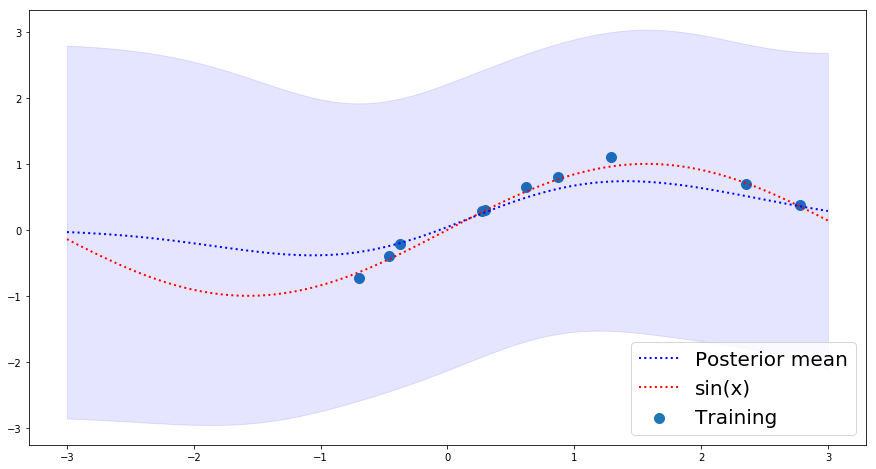

In [8]:
post_mean = m.predict_y(x_test)[0]
post_var = m.predict_y(x_test)[1]

upper_bound = post_mean + 2 * np.sqrt(post_var)
lower_bound = post_mean - 2 * np.sqrt(post_var)

plt.figure(figsize=(15,8))
plt.scatter(x_train,y_train,label='Training',s=100)
plt.plot(x_test,post_mean,'b:', label='Posterior mean',linewidth=2)
plt.fill_between(x_test.reshape((M,)),lower_bound.reshape((M,)),upper_bound.reshape((M,)),alpha=0.1,color='b')
plt.plot(x_test,y_true,'r:', label='sin(x)',linewidth=2)
plt.legend(scatterpoints=1,fontsize=20,loc=4)
# plt.savefig('basic_examp' + '.pdf',bbox_inches='tight')
plt.show()

## Optimise hyperparameters

In [9]:
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -1.688925
  Number of iterations: 11
  Number of functions evaluations: 15


## Display model with optimised hyperparameters

In [10]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/variance,Parameter,None,+ve,True,(),True,0.8953836478447492
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,1.6581369189895558
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.006308889439539035


## Plotting results

In [11]:
post_mean = m.predict_y(x_test)[0]
post_var = m.predict_y(x_test)[1]

upper_bound = post_mean + 2 * np.sqrt(post_var)
lower_bound = post_mean - 2 * np.sqrt(post_var)

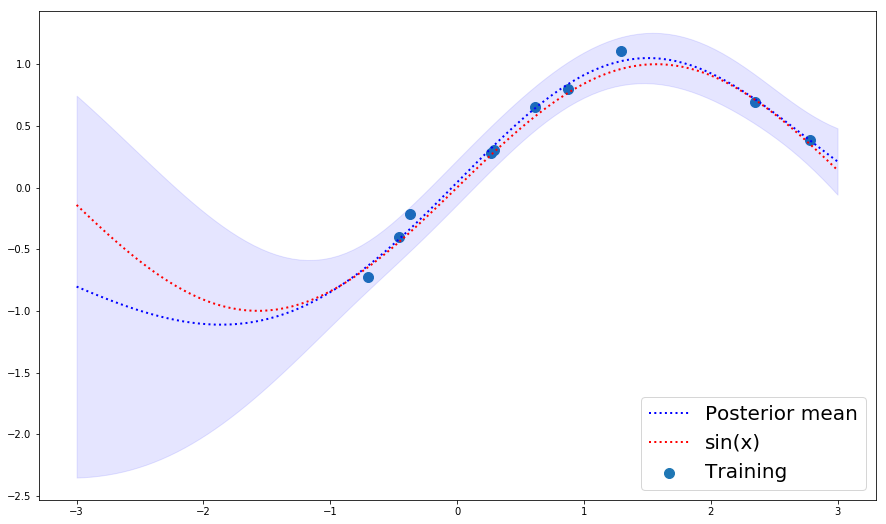

In [12]:
plt.figure(figsize=(15,9))
plt.scatter(x_train,y_train,label='Training',s=100)
plt.plot(x_test,post_mean,'b:', label='Posterior mean',linewidth=2)
plt.fill_between(x_test.reshape((M,)),lower_bound.reshape((M,)),upper_bound.reshape((M,)),alpha=0.1,color='b')
plt.plot(x_test,y_true,'r:', label='sin(x)',linewidth=2)
plt.legend(scatterpoints=1,fontsize=20,loc=4)
# plt.savefig('basic_examp' + '.pdf',bbox_inches='tight')
plt.show()




## Showing some kernels

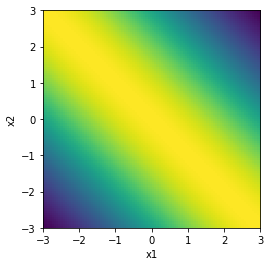

In [13]:
# Plotting a squared exponential function between 0 and 3
T = 100
t = np.linspace(0,3,T).reshape(T,1)
plt.figure()
plt.imshow(kernel.compute_K_symm(t),extent=[-3,3,-3,3])
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

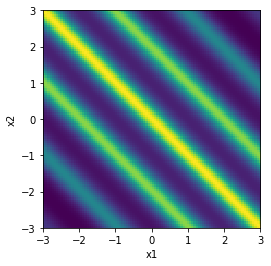

In [14]:
# Plot periodic kernel * RBF
kernel_per = gpflow.kernels.Periodic(input_dim=1, variance=1., lengthscales=.5) * kernel
plt.imshow(kernel_per.compute_K_symm(t),extent=[-3,3,-3,3])
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

### Plot some more kernels:

Here we plot kernels by sampling from multivariate normals with covariances defined by kernels:

$$ \mathbf{f} \sim \mathcal{N}(\mathbf{0},\mathbf{K}) $$

* For example, any sample from a GP with a periodic kernel will result in a function with a periodicity.

(-3, 3)

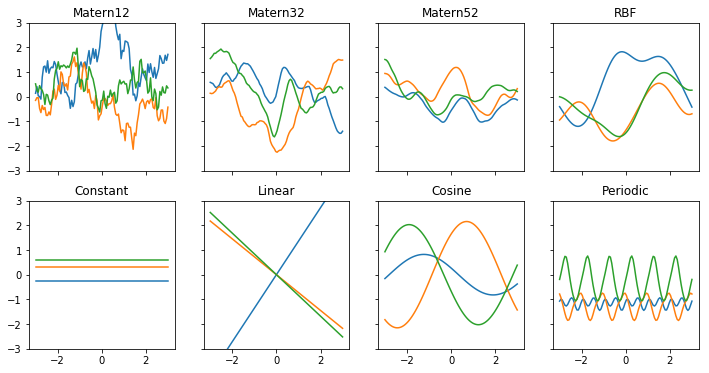

In [15]:
def plotkernelsample(k, ax, xmin=-3, xmax=3):
    xx = np.linspace(xmin, xmax, 100)[:,None]
    K = k.compute_K_symm(xx)
    ax.plot(xx, np.random.multivariate_normal(np.zeros(100), K, 3).T)
    ax.set_title(k.__class__.__name__)

def plotkernelfunction(K, ax, xmin=-3, xmax=3, other=0):
    xx = np.linspace(xmin, xmax, 100)[:,None]
    K = k.compute_K_symm(xx)
    ax.plot(xx, k.compute_K(xx, np.zeros((1,1)) + other))
    ax.set_title(k.__class__.__name__ + ' k(x, %f)'%other)


f, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
plotkernelsample(gpflow.kernels.Matern12(1), axes[0,0])
plotkernelsample(gpflow.kernels.Matern32(1), axes[0,1])
plotkernelsample(gpflow.kernels.Matern52(1), axes[0,2])
plotkernelsample(gpflow.kernels.RBF(1), axes[0,3])
plotkernelsample(gpflow.kernels.Constant(1), axes[1,0])
plotkernelsample(gpflow.kernels.Linear(1), axes[1,1])
plotkernelsample(gpflow.kernels.Cosine(1), axes[1,2])
plotkernelsample(gpflow.kernels.Periodic(1), axes[1,3])
axes[0,0].set_ylim(-3, 3)

### Classification

* You can also do classification with a GP.
* However, during inference, you have to squash the GP through a sigmoid function. 

$$ p (y\mid x) = \int p(y \mid x , f) p(f \mid x, \theta) $$

* $f$ is our GP from before but this integral is intractable because our likelihood is a sigmoid rather than a conjugate Gaussian likelhood as we used in regression.

* This means making an approximation. Here I have taken the example from the gpflow website, which applies the technique from this paper: [Hensman, Matthews, Ghahramani, AISTATS 2015, Scalable Variational Gaussian Process Classification]

In [16]:
from sklearn.datasets import make_moons, make_circles, make_classification

N = 100
M = 100

m1= 0.5
m2=-0.5

Xtrain = np.concatenate([np.random.normal(m1,1,(N,2)),np.random.normal(m2,1,(N,2))],axis=0)
# x_train = np.linspace(-2.,2.,N).reshape((N,1))
Ytrain = np.concatenate([np.ones((N,1)),np.zeros((N,1))],axis=0)


x_test = np.concatenate([np.random.normal(m1,1,(M,2)),np.random.normal(m2,1,(M,2))],axis=0)
y_true = np.concatenate([np.ones((M,1)),np.zeros((M,1))],axis=0)



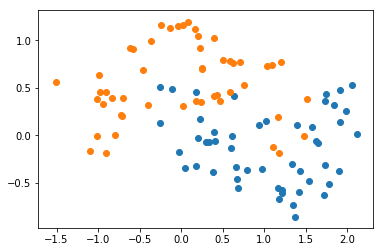

In [17]:
Xtrain, Ytrain = make_moons(n_samples=N,noise=.25)
x_test, y_true = make_moons(n_samples=N,noise=.25)

plt.scatter(Xtrain[:,0][Ytrain[:]==1], Xtrain[:,1][Ytrain[:]==1])
plt.scatter(Xtrain[:,0][Ytrain[:]==0], Xtrain[:,1][Ytrain[:]==0])

Ytrain = Ytrain.reshape((-1,1))
y_true = y_true.reshape((-1,1))

In [18]:
def gridParams():
    mins = [-3.25,-2.85 ]
    maxs = [ 3.65, 3.4 ]
    nGrid = 50
    xspaced = np.linspace(mins[0], maxs[0], nGrid)
    yspaced = np.linspace(mins[1], maxs[1], nGrid)
    xx, yy = np.meshgrid(xspaced, yspaced)
    Xplot = np.vstack((xx.flatten(),yy.flatten())).T
    return mins, maxs, xx, yy, Xplot

def plot(m, ax):
    col1 = '#0172B2'
    col2 = '#CC6600'
    mins, maxs, xx, yy, Xplot = gridParams()
    p = m.predict_y(Xplot)[0]
    ax.plot(Xtrain[:,0][Ytrain[:,0]==1], Xtrain[:,1][Ytrain[:,0]==1], 'o', color=col1, mew=0, alpha=0.5)
    ax.plot(Xtrain[:,0][Ytrain[:,0]==0], Xtrain[:,1][Ytrain[:,0]==0], 'o', color=col2, mew=0, alpha=0.5)
    if hasattr(m, 'feat') and hasattr(m.feat, 'Z'):
        Z = m.feature.Z.read_value()
        ax.plot(Z[:,0], Z[:,1], 'ko', mew=0, ms=4)
        ax.set_title('m={}'.format(Z.shape[0]))
    else:
        ax.set_title('full')
    ax.contour(xx, yy, p.reshape(*xx.shape), [0.5], colors='k', linewidths=1.8, zorder=100)

In [19]:

# Setup the experiment and plotting.
Ms = [4, 8, 16, 32, 64]

# Run sparse classification with increasing number of inducing points
models = []
for index, num_inducing in enumerate(Ms):
    # kmeans for selecting Z
    from scipy.cluster.vq import kmeans
    Z = kmeans(Xtrain, num_inducing)[0]

    m = gpflow.models.SVGP(
        Xtrain, Ytrain, kern=gpflow.kernels.RBF(2),
        likelihood=gpflow.likelihoods.Bernoulli(), Z=Z)
    # Initially fix the hyperparameters.
    m.feature.set_trainable(False)
    gpflow.train.ScipyOptimizer().minimize(m, maxiter=20)

    # Unfix the hyperparameters.
    m.feature.set_trainable(True)
    gpflow.train.ScipyOptimizer(options=dict(maxiter=200)).minimize(m)
    models.append(m)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 41.308894
  Number of iterations: 21
  Number of functions evaluations: 23
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 40.765896
  Number of iterations: 515
  Number of functions evaluations: 556
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 36.320115
  Number of iterations: 21
  Number of functions evaluations: 25
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 35.177473
  Number of iterations: 391
  Number of functions evaluations: 413
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 35.375438
  Number of iterat

In [20]:
# Run variational approximation without sparsity..
# ..be aware that this is much slower for big datasets,
# but relatively quick here.
m = gpflow.models.VGP(Xtrain, Ytrain,
                      kern=gpflow.kernels.RBF(2),
                      likelihood=gpflow.likelihoods.Bernoulli())
gpflow.train.ScipyOptimizer().minimize(m, maxiter=2000)
models.append(m)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 34.773433
  Number of iterations: 137
  Number of functions evaluations: 155


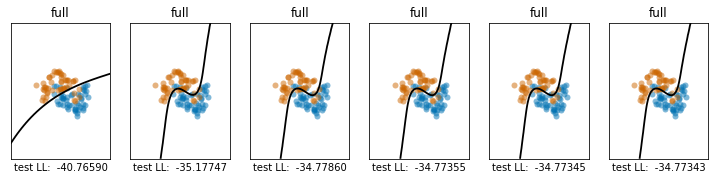

In [21]:
# make plots.
fig, axes = plt.subplots(1, len(models), figsize=(12.5, 2.5), sharex=True, sharey=True)
for i, m in enumerate(models):
    plot(m, axes[i])
    axes[i].set_yticks([])
    axes[i].set_xticks([])
    axes[i].set_xlabel('test LL:  %.5f' % m.compute_log_likelihood(x_test,y_true))

### Bayesian optimisation
 * If you have a scenario with an expensive to compute black box function and you need to optimise the parameters.
 * https://sheffieldml.github.io/GPyOpt/firstexamples/index.html
 * Works with functions that are not differentiable.

### Coregionalisation
* This is a scenario where you may have multiple data sets which are related.
* Can we make predictions on one data set based on a learnt correlation with a correlated data set?

#### First make the data set:
* Two out of phase signals

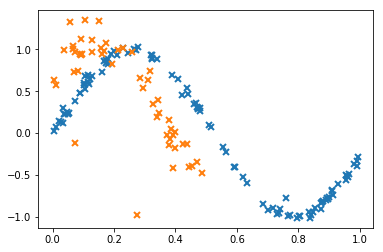

In [22]:

# make a dataset with two outputs, correlated, heavy-tail noise. One has more noise than the other.
X1 = np.random.rand(100, 1)
X2 = np.random.rand(50, 1) * 0.5
Y1 = np.sin(6*X1) + np.random.standard_t(3, X1.shape)*0.03
Y2 = np.sin(6*X2+ 0.7) + np.random.standard_t(3, X2.shape)*0.1

plt.plot(X1, Y1, 'x', mew=2)
plt.plot(X2, Y2, 'x', mew=2);

### No coregionalisation
* First we fit to the two of them separately.

In [23]:
k1 = gpflow.kernels.Matern32(1)
k2 = gpflow.kernels.Matern32(1)

m1 = gpflow.models.GPR(X1, Y1, kern=k1)
m2 = gpflow.models.GPR(X2, Y2, kern=k2)

opt1 = gpflow.train.ScipyOptimizer()
opt1.minimize(m1)

opt2 = gpflow.train.ScipyOptimizer()
opt2.minimize(m2)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -144.023482
  Number of iterations: 15
  Number of functions evaluations: 21
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 21.547296
  Number of iterations: 14
  Number of functions evaluations: 18


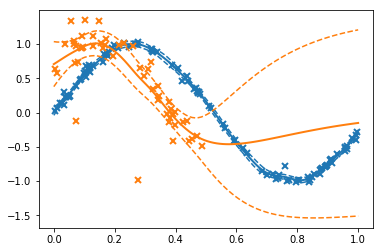

In [24]:
def plot_gp(x, mu, var, color='k'):
    plt.plot(x, mu, color=color, lw=2)
    plt.plot(x, mu + 2*np.sqrt(var), '--', color=color)
    plt.plot(x, mu - 2*np.sqrt(var), '--', color=color)
    
def plot1(m,X,Y):
    xtest = np.linspace(0, 1, 100)[:,None]
    line, = plt.plot(X, Y, 'x', mew=2)
    mu, var = m.predict_f(np.hstack((xtest, np.zeros_like(xtest))))
    plot_gp(xtest, mu, var, line.get_color())

plot1(m1,X1,Y1)
plot1(m2,X2,Y2)

* Notice how the orange curve reverts to its mean and increases its uncertainty away from the data.
* It does not use the other GP at all despite the obvious similarities between the two.

In [25]:
# a Coregionalization kernel. The base kernel is Matern 3/2, and acts on the first ([0]) data dimension.
# the 'Coregion' kernel indexes the outputs, and acts on the second ([1]) data dimension
k1 = gpflow.kernels.Matern32(1, active_dims=[0])
coreg = gpflow.kernels.Coregion(1, output_dim=2, rank=1, active_dims=[1])
kern = k1 * coreg

# build a variational model. This likelihood switches between Student-T noise with different variances:
lik = gpflow.likelihoods.SwitchedLikelihood([gpflow.likelihoods.StudentT(), gpflow.likelihoods.StudentT()])

# Augment the time data with ones or zeros to indicate the required output dimension
X_augmented = np.vstack((np.hstack((X1, np.zeros_like(X1))), np.hstack((X2, np.ones_like(X2)))))

# Augment the Y data to indicate which likelihood we should use
Y_augmented = np.vstack((np.hstack((Y1, np.zeros_like(X1))), np.hstack((Y2, np.ones_like(X2)))))

# now build the GP model as normal
m = gpflow.models.VGP(X_augmented, Y_augmented, kern=kern, likelihood=lik, num_latent=1)

In [26]:
# fit the covariance function parameters
gpflow.train.ScipyOptimizer().minimize(m, maxiter=1000)

/Users/adcobb/anaconda/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -147.893954
  Number of iterations: 866
  Number of functions evaluations: 951


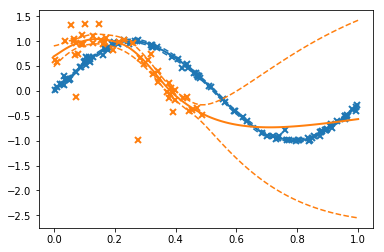

In [69]:
def plot_gp(x, mu, var, color='k'):
    plt.plot(x, mu, color=color, lw=2)
    plt.plot(x, mu + 2*np.sqrt(var), '--', color=color)
    plt.plot(x, mu - 2*np.sqrt(var), '--', color=color)

def plot(m):
    xtest = np.linspace(0, 1, 100)[:,None]
    line, = plt.plot(X1, Y1, 'x', mew=2)
    mu, var = m.predict_f(np.hstack((xtest, np.zeros_like(xtest))))
    plot_gp(xtest, mu, var, line.get_color())

    line, = plt.plot(X2, Y2, 'x', mew=2)
    mu, var = m.predict_f(np.hstack((xtest, np.ones_like(xtest))))
    plot_gp(xtest, mu, var, line.get_color())
    

plot(m)

* Slightly better but not quite what we want.
* Let's look at the hyperparameters:

In [71]:
m.kern.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
VGP/kern/matern32/variance,Parameter,None,+ve,True,(),True,1.0975774915718322
VGP/kern/matern32/lengthscales,Parameter,None,+ve,True,(),True,0.5607711118511686
VGP/kern/coregion/W,Parameter,None,(none),True,"(2, 1)",True,"[[0.0], [0.0]]"
VGP/kern/coregion/kappa,Parameter,None,+ve,True,"(2,)",True,"[0.683038376507472, 1.3439637851923925]"


In [74]:
coreg.W.value.T + np.diag(coreg.kappa.value)

array([[1.72150092, 1.27845935],
       [1.17863625, 2.76782033]])

In [79]:
print('Log likelihood: ', m.compute_log_likelihood(X_augmented, Y_augmented))

Log likelihood:  149.50964036389354


* For some reason our W hyperparameter got stuck in a local minima and ended up as [[0,0]]
* Let's reinitialise:

In [72]:
m.kern.coregion.W = np.random.randn(2, 1)

In [73]:
gpflow.train.ScipyOptimizer().minimize(m, maxiter=2000)

/Users/adcobb/anaconda/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -149.509640
  Number of iterations: 1188
  Number of functions evaluations: 1297


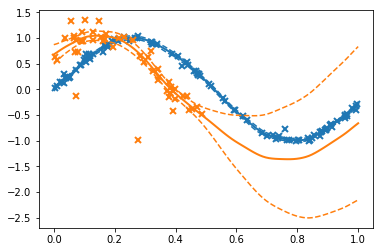

In [75]:
plot(m)

In [76]:
coreg.W.value.T + np.diag(coreg.kappa.value)

array([[1.72150092, 1.27845935],
       [1.17863625, 2.76782033]])

In [77]:
print('Log likelihood: ', m.compute_log_likelihood(X_augmented, Y_augmented))

149.50964036389354